/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Metrics Summary:
----------------------------------------
ARIMA  - MAE: 0.9785, MSE: 1.3644
SARIMA - MAE: 1.0067, MSE: 1.3926
LSTM   - MAE: 0.4199, MSE: 0.2786
GRU    - MAE: 0.4181, MSE: 0.2693
CNN    - MAE: 0.3796, MSE: 0.2235


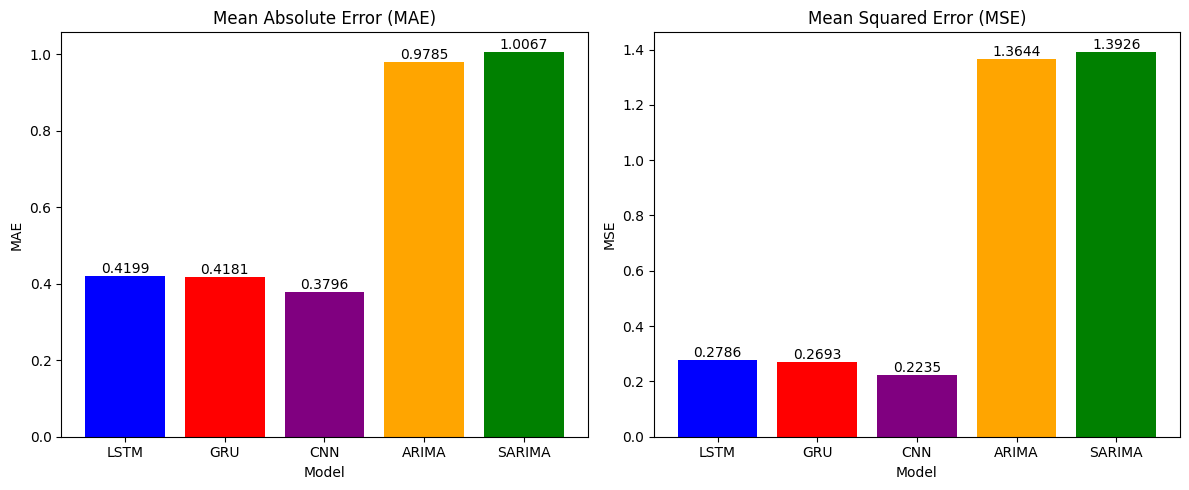

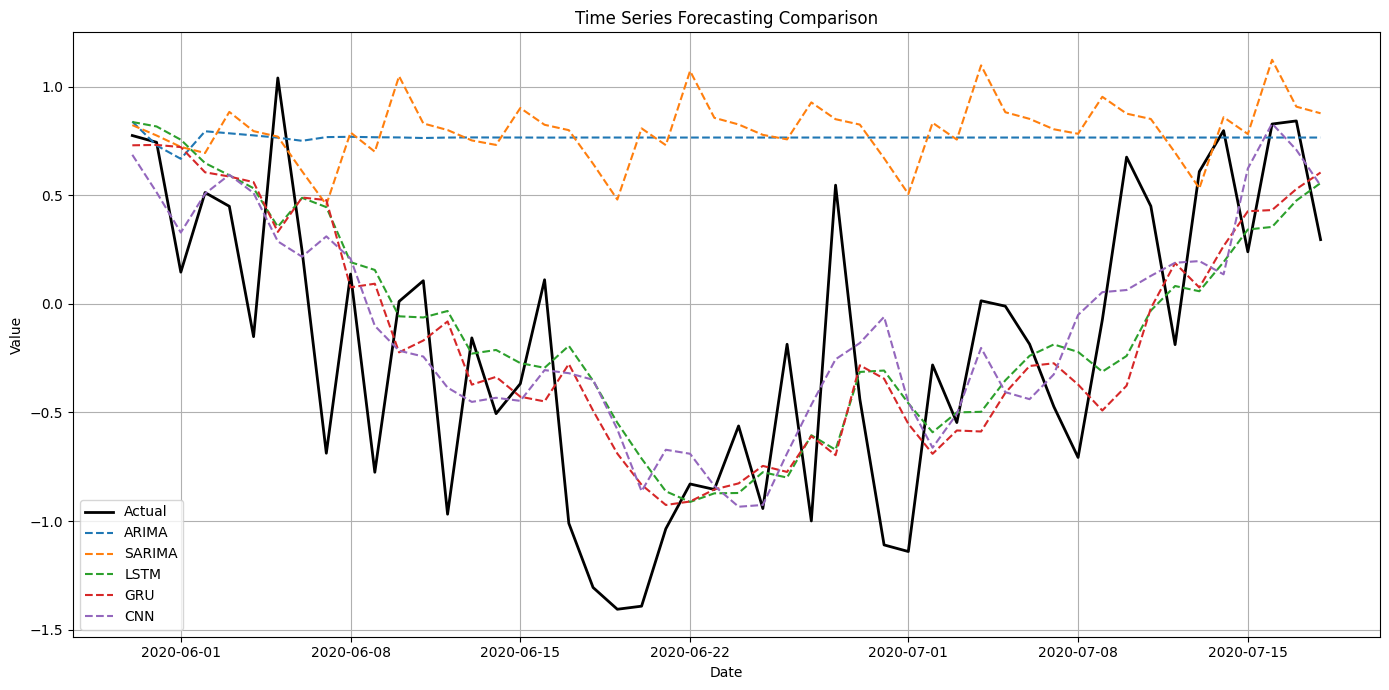

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# ---------------------------
# 1. Generating Synthetic Data
# ---------------------------
np.random.seed(42)
time = np.arange(0, 200)
# Creating a sine wave with noise
data = np.sin(0.1 * time) + np.random.normal(scale=0.5, size=len(time))
dates = pd.date_range(start="2020-01-01", periods=len(data))
df = pd.DataFrame(data, index=dates, columns=["value"])

# ---------------------------
# 2. Splitting Data into Train/Test
# ---------------------------
train_size = 150
train, test = df.iloc[:train_size], df.iloc[train_size:]

# ---------------------------
# 3. ARIMA Model
# ---------------------------
# Fitting an ARIMA model on the training data.
arima_model = sm.tsa.ARIMA(train["value"], order=(5, 1, 0)).fit()
# Forecasting for the length of the test set.
pred_arima = arima_model.forecast(steps=len(test))

# ---------------------------
# 4. SARIMA Model (Seasonal ARIMA)
# ---------------------------
# Here we use SARIMAX to model seasonality.
sarima_model = sm.tsa.statespace.SARIMAX(train["value"],
                                         order=(1, 1, 1),
                                         seasonal_order=(1, 1, 1, 12)).fit(disp=False)
pred_sarima = sarima_model.forecast(steps=len(test))

# ---------------------------
# 5. Data Preparation for Neural Networks
# ---------------------------
# Preparing the data: creating sliding windows from the training series.
window_size = 10

def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

train_series = train["value"].values
X_train, y_train = create_dataset(train_series, window_size)

# ---------------------------
# 6. LSTM Model
# ---------------------------
# Reshaping for LSTM: (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Building a simple LSTM model.
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Training the LSTM model.
lstm_model.fit(X_train_reshaped, y_train, epochs=20, verbose=0)

# Generate LSTM predictions using a rolling forecast.
lstm_predictions = []
# In order to predict on the test set, we need to include the last 'window_size' points from training.
test_series = df["value"].values[train_size - window_size:]
for i in range(len(test)):
    X_input = test_series[i:i + window_size]
    X_input = X_input.reshape((1, window_size, 1))
    pred = lstm_model.predict(X_input, verbose=0)
    lstm_predictions.append(pred[0, 0])
    test_series = np.append(test_series, pred[0, 0])  # updating series for next prediction

pred_lstm = np.array(lstm_predictions)

# ---------------------------
# 7. GRU Model (NEW)
# ---------------------------
# Building a GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(window_size, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

# Training the GRU model
gru_model.fit(X_train_reshaped, y_train, epochs=20, verbose=0)

# Generate GRU predictions using a rolling forecast
gru_predictions = []
test_series = df["value"].values[train_size - window_size:]
for i in range(len(test)):
    X_input = test_series[i:i + window_size]
    X_input = X_input.reshape((1, window_size, 1))
    pred = gru_model.predict(X_input, verbose=0)
    gru_predictions.append(pred[0, 0])
    test_series = np.append(test_series, pred[0, 0])  # updating series for next prediction

pred_gru = np.array(gru_predictions)

# ---------------------------
# 8. CNN Model (NEW)
# ---------------------------
# Building a CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')

# Training the CNN model
cnn_model.fit(X_train_reshaped, y_train, epochs=20, verbose=0)

# Generate CNN predictions using a rolling forecast
cnn_predictions = []
test_series = df["value"].values[train_size - window_size:]
for i in range(len(test)):
    X_input = test_series[i:i + window_size]
    X_input = X_input.reshape((1, window_size, 1))
    pred = cnn_model.predict(X_input, verbose=0)
    cnn_predictions.append(pred[0, 0])
    test_series = np.append(test_series, pred[0, 0])  # updating series for next prediction

pred_cnn = np.array(cnn_predictions)

# ---------------------------
# 9. Calculating Error Metrics
# ---------------------------
mae_arima  = mean_absolute_error(test["value"], pred_arima)
mse_arima  = mean_squared_error(test["value"], pred_arima)

mae_sarima = mean_absolute_error(test["value"], pred_sarima)
mse_sarima = mean_squared_error(test["value"], pred_sarima)

mae_lstm   = mean_absolute_error(test["value"], pred_lstm)
mse_lstm   = mean_squared_error(test["value"], pred_lstm)

mae_gru    = mean_absolute_error(test["value"], pred_gru)
mse_gru    = mean_squared_error(test["value"], pred_gru)

mae_cnn    = mean_absolute_error(test["value"], pred_cnn)
mse_cnn    = mean_squared_error(test["value"], pred_cnn)

# Print error metrics for all models
print("Model Metrics Summary:")
print("-" * 40)
print(f"ARIMA  - MAE: {mae_arima:.4f}, MSE: {mse_arima:.4f}")
print(f"SARIMA - MAE: {mae_sarima:.4f}, MSE: {mse_sarima:.4f}")
print(f"LSTM   - MAE: {mae_lstm:.4f}, MSE: {mse_lstm:.4f}")
print(f"GRU    - MAE: {mae_gru:.4f}, MSE: {mse_gru:.4f}")
print(f"CNN    - MAE: {mae_cnn:.4f}, MSE: {mse_cnn:.4f}")

# ---------------------------
# 10. Plotting Bar Graphs for Errors
# ---------------------------
models = ['LSTM', 'GRU', 'CNN', 'ARIMA', 'SARIMA']
mae_values = [mae_lstm, mae_gru, mae_cnn, mae_arima, mae_sarima]
mse_values = [mse_lstm, mse_gru, mse_cnn, mse_arima, mse_sarima]

# Set the figure size for bar charts
plt.figure(figsize=(12, 5))

# MAE Bar Graph
plt.subplot(1, 2, 1)
bars = plt.bar(models, mae_values, color=['blue', 'red', 'purple', 'orange', 'green'])
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.ylabel('MAE')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', rotation=0)

# MSE Bar Graph
plt.subplot(1, 2, 2)
bars = plt.bar(models, mse_values, color=['blue', 'red', 'purple', 'orange', 'green'])
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.ylabel('MSE')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', rotation=0)

plt.tight_layout()

# ---------------------------
# 11. Plotting Predictions
# ---------------------------
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['value'], label='Actual', color='black', linewidth=2)
plt.plot(test.index, pred_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, pred_sarima, label='SARIMA', linestyle='--')
plt.plot(test.index, pred_lstm, label='LSTM', linestyle='--')
plt.plot(test.index, pred_gru, label='GRU', linestyle='--')
plt.plot(test.index, pred_cnn, label='CNN', linestyle='--')
plt.title('Time Series Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()